# **IMPORT REQUIRED LIBRARIES**

In [ ]:
import numpy as np
from PIL import Image
from skimage.transform import resize
import scipy
import torch
from tqdm import tqdm
# from loss_function import *
# from DLinkNet101 import *
import os
import cv2

In [ ]:
import torch
from torch import nn
from torchvision import models

# **PARAMETERS REQUIRED**
During training n inferencing

In [ ]:
training_resize = 384
# The number of resized training pairs used for data augmentation
training_number = 1
# The resolution of resized testing images 500 is image width and height
testing_resize = int(608 * training_resize / 500)
if testing_resize % 2 == 1:
    testing_resize += 1
print(testing_resize)

466


# **ACCESS GPU**

In [ ]:
cuda_available = torch.cuda.is_available()
if cuda_available:
    print('CUDA is available. Utilize GPUs for computation')
    device = torch.device("cuda")
else:
    print('CUDA is not available. Utilize CPUs for computation.')
    device = torch.device("cpu")

CUDA is available. Utilize GPUs for computation


# **DEFINE NEURAL NETWORK**

In [ ]:
class dilation_block(nn.Module):
    # Instantiate all the modules
    def __init__(self,channel):
        super(dilation_block, self).__init__()
        self.dilate1 = nn.Conv2d(channel, channel, kernel_size=3, dilation=1, padding=1)
        self.dilate2 = nn.Conv2d(channel, channel, kernel_size=3, dilation=2, padding=2)
        self.dilate3 = nn.Conv2d(channel, channel, kernel_size=3, dilation=4, padding=4)
        self.dilate4 = nn.Conv2d(channel, channel, kernel_size=3, dilation=8, padding=8)
        self.dilate5 = nn.Conv2d(channel, channel, kernel_size=3, dilation=16, padding=16)
        for module in self.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d):
                if module.bias is not None:
                    module.bias.data.zero_()

        self.relu1 = nn.ReLU(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)
        self.relu3 = nn.ReLU(inplace=True)
        self.relu4 = nn.ReLU(inplace=True)
        self.relu5 = nn.ReLU(inplace=True)

    # Define the block structure
    def forward(self, x):
        """
        dilation_block's forward function.
        Args:
            x (tensor): input tensor
        Returns:
            o1 (tensor): the output of this block after processing
        """
        d1 = self.relu1(self.dilate1(x))
        d2 = self.relu2(self.dilate2(d1))
        d3 = self.relu3(self.dilate3(d2))
        d4 = self.relu4(self.dilate4(d3))
        d5 = self.relu5(self.dilate5(d4))

        o1 = x + d1 + d2 + d3 + d4 + d5
        return o1


class decoder_block(nn.Module):
    # Instantiate all the modules
    def __init__(self, in_channels, out_channels):
        super(decoder_block,self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 4, kernel_size=1),
            nn.BatchNorm2d(in_channels // 4),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=3,
                               stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(in_channels // 4),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels // 4, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    # Define the block structure
    def forward(self, x):
        """
        decoder_block's forward function.
        Args:
            x (tensor): input tensor
        Returns:
            x (tensor): the output of this block after processing
        """
        x = self.block(x)
        return x



class DLinkNet101(nn.Module):
    # Instantiate all the modules
    def __init__(self):
        super(DLinkNet101, self).__init__()
        # Construct a ResNet-101 architecture from https://arxiv.org/pdf/1512.03385.pdf
        # Return a model pre-trained on ImageNet
        resnet = models.resnet101(pretrained=True)

        # Input Block
        self.input_block = nn.Sequential(*list(resnet.children())[0:4])

        # Encoder Blocks
        self.encoder1 = nn.Sequential(*list(resnet.children())[4])
        self.encoder2 = nn.Sequential(*list(resnet.children())[5])
        self.encoder3 = nn.Sequential(*list(resnet.children())[6])
        self.encoder4 = nn.Sequential(*list(resnet.children())[7])

        # Dilation Block
        self.dilation = dilation_block(2048)

        # Decoder Blocks
        self.decoder4 = decoder_block(2048, 1024)
        self.decoder3 = decoder_block(1024, 512)
        self.decoder2 = decoder_block(512, 256)
        self.decoder1 = decoder_block(256, 256)

        # Output Block
        self.output_block = nn.Sequential(
            nn.ConvTranspose2d(256, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    # Define the network structure
    def forward(self, x):
        """
        DLinkNet101's forward function.
        Args:
            x (tensor): input tensor
        Returns:
            o1 (tensor): the output of this model after processing
        """
        # Input
        i1 = self.input_block(x)

        # Encoding
        e1 = self.encoder1(i1)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Dilation
        e4 = self.dilation(e4)

        # Decoding
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)

        # Output
        o1 = self.output_block(d1)

        return o1



# **LOSS FUNCTION**

In [ ]:
import numpy as np
import torch
from torch import nn

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()
        self.bce_loss = nn.BCELoss()

    def forward(self, outputs, targets, smooth=0):
        """
        DiceBCELoss - Compute the Dice-BCE Loss.
        Args:
            outputs (tensor): output tensor
            targets (tensor): target tensor
        Returns:
            dice_BCE_loss (tensor): the Dice-BCE Loss
        """
        # Flatten output and target tensors
        outputs = outputs.view(-1)
        targets = targets.view(-1)

        # Compute the dice Loss
        intersection = (outputs * targets).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (outputs.sum() + targets.sum() + smooth)

        # Compute the standard binary cross-entropy (BCE) loss
        BCE_loss = self.bce_loss(outputs, targets)

        dice_BCE_loss = dice_loss + BCE_loss

        return dice_BCE_loss


class BCEIoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(BCEIoULoss, self).__init__()
        self.bce_loss = nn.BCELoss()

    def forward(self, outputs, targets, beta=0.6, alpha=0.25, gamma=3, smooth=0):
        """
        BCEIoULoss - Compute the BCEIoULoss Loss.
        Args:
            outputs (tensor): output tensor
            targets (tensor): target tensor
        Returns:
            BCE_IoU_loss (tensor): the BCE-IoU Loss
        """
        # Flatten output and target tensors
        outputs = outputs.view(-1)
        targets = targets.view(-1)

        # Compute the intersection-over-union (IoU) loss
        intersection = (outputs * targets).sum()
        total = (outputs + targets).sum()
        union = total - intersection
        IoU_loss = 1 - (intersection + smooth) / (union + smooth)

        # Compute the modified BCE loss
        BCE_loss = self.bce_loss(outputs, targets)
        BCE_exp = torch.exp(-BCE_loss)
        modified_BCE_loss = alpha * (1 - BCE_exp) ** gamma * BCE_loss

        BCE_IoU_loss = beta * modified_BCE_loss + (1 - beta) * IoU_loss

        return BCE_IoU_loss

# **INFERENCE FUNCTION**

In [ ]:
def testing_patch_extracting(input, trar=384, tesr=466):
    """
    testing_patch_extracting - Divide each resized testing image into four patches, one at each corner.
    Args:
        input (numpy) - the resized testing image
        trar (int) - the resolution of resized training images and the corresponding masks
        tesr (int) - the resolution of resized testing images
    Returns:
        input_patches (numpy) - the four patches
    """
    if tesr / 2 > trar:
        raise AssertionError("training_resize is too small.")

    input_patches = np.empty(shape=(4, input.shape[2], trar, trar))
    input_patches[0] = np.transpose(input[0:0+trar, 0:0+trar, :], (2, 0, 1))
    input_patches[1] = np.transpose(input[0:0+trar, tesr-trar:tesr, :], (2, 0, 1))
    input_patches[2] = np.transpose(input[tesr-trar:tesr, 0:0+trar, :], (2, 0, 1))
    input_patches[3] = np.transpose(input[tesr-trar:tesr, tesr-trar:tesr, :], (2, 0, 1))

    return input_patches


def testing_patch_assembling(output_patches, trar=384, tesr=584):
    """
    testing_patch_assembling - Merge the four masks into one resized mask.
    Args:
        output_patches (numpy) - the masks of the four patches
        trar (int) - the resolution of resized training images and the corresponding masks
        tesr (int) - the resolution of resized testing images
    Returns:
        output (numpy) - the resized mask
    """
    # The extracting length
    eL = int(tesr / 2)

    output = np.empty(shape=(output_patches.shape[1], tesr, tesr))
    output[:, 0:eL, 0:eL] = output_patches[0, :, 0:eL, 0:eL]
    output[:, 0:eL, tesr-eL:tesr] = output_patches[1, :, 0:eL, trar-eL:trar]
    output[:, tesr-eL:tesr, 0:eL] = output_patches[2, :, trar-eL:trar, 0:eL]
    output[:, tesr-eL:tesr, tesr-eL:tesr] = output_patches[3, :, trar-eL:trar, trar-eL:trar]

    return output

def mask_to_submission(output, index):
    """
    mask_to_submission - Convert the mask of each testing image into the submission format.
    Args:
        output (numpy) - the mask of the testing image
        index (int) - the index of the testing image
    Returns:
        mask_submission (list) - the submission format of the mask
    """
    mask_submission = []
    for i in range(0, output.shape[0], 16):
        for j in range(0, output.shape[1], 16):
            prediction = 0
            patch = output[j:j+16, i:i+16]
            if np.mean(patch > 0.2) > 0.25:
                prediction = 1
            mask_submission.append(["{:03d}_{}_{}".format(index, i, j), prediction])
    return mask_submission


def submission_creating(model, path_testing='test_set_images/', training_resize=384, testing_resize=584, cuda_available=True):
    """
    submission_creating - Load and generate the resized training dataset and validation dataset.
    Args:
        model (torch): the instance of the neural network
        path_testing (str): the location in your Google Drive or local file system
        training_resize (int): the resolution of resized training images and their corresponding masks (training pairs) (default: 384)
        testing_resize (int): the resolution of resized testing images (default: 584)
        cuda_available (bool): the flag indicating whether CUDA is available (default: True)
    Returns:
        submission (numpy): the final submission file
    """
    submit_outputs = []

    for index,filename in enumerate(os.listdir(path_testing)):
        if filename.lower().endswith('jpg'):
            image_path = os.path.join(path_testing, filename)

            # Load a testing image using OpenCV
            input = cv2.imread(image_path)
            input = cv2.cvtColor(input, cv2.COLOR_BGR2RGB).astype('float32') / 255

            # Resize the testing image
            input = resize(input, (testing_resize, testing_resize))

            # Divide the resized testing image into four patches, one at each corner.
            input_patches = testing_patch_extracting(input, training_resize, testing_resize)
            input_patches = torch.from_numpy(input_patches).float()

            # Predict the mask of the four patches
            if cuda_available:
                output_patches = model(input_patches.cuda()).detach().cpu().numpy()
            else:
                output_patches = model(input_patches).detach().numpy()

            # Merge the four masks into one resized mask
            output = testing_patch_assembling(output_patches, training_resize, testing_resize)[0, :, :]

            # Restore the resized mask to the original resolution
            output = resize(output, (608, 608))

            # Convert the mask of the testing image into the submission format
            submit_output = mask_to_submission(output, index)

            submit_outputs.append(submit_output)

    submission = np.concatenate(submit_outputs, axis=0)
    submission = np.concatenate(([['id', 'prediction']], submission), axis=0)

    return submission


# **ACCESS MODEL**

In [ ]:
model = DLinkNet101()
if cuda_available:
    # Move the model to GPU
    model.cuda()
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 156MB/s]


DLinkNet101(
  (input_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (encoder1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256

COPY MODEL TO CONTENT FOLDER


In [ ]:
!cp -r /content/drive/MyDrive/Office_content/project/models /content/

In [ ]:
path_model="/content/models/"

checkpoint = torch.load(path_model + 'model.model') #gpu
# cpu
# checkpoint = torch.load(path_model + 'model.model',map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

DLinkNet101(
  (input_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (encoder1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256

# **UNZIP TEST DATA N INFER**

In [ ]:
!unzip /content/val.zip

Archive:  /content/val.zip
   creating: val/
  inflating: val/Abyssinian_80.jpg   
  inflating: val/Abyssinian_81.jpg   
  inflating: val/Abyssinian_82.jpg   
  inflating: val/Abyssinian_83.jpg   
  inflating: val/Abyssinian_84.jpg   
  inflating: val/Abyssinian_85.jpg   
  inflating: val/Abyssinian_86.jpg   
  inflating: val/Abyssinian_87.jpg   
  inflating: val/Abyssinian_88.jpg   
  inflating: val/Abyssinian_89.jpg   
  inflating: val/Abyssinian_90.jpg   
  inflating: val/Abyssinian_91.jpg   
  inflating: val/Abyssinian_92.jpg   
  inflating: val/Abyssinian_93.jpg   
  inflating: val/Abyssinian_94.jpg   
  inflating: val/Abyssinian_95.jpg   
  inflating: val/Abyssinian_96.jpg   
  inflating: val/Abyssinian_97.jpg   
  inflating: val/Abyssinian_98.jpg   
  inflating: val/Abyssinian_99.jpg   
  inflating: val/Abyssinian_100.jpg  
  inflating: val/Abyssinian_100.mat  
  inflating: val/Abyssinian_101.jpg  
  inflating: val/Abyssinian_101.mat  
  inflating: val/Abyssinian_102.jpg  
  inf

In [ ]:
testing_path = "/content/val"

submission = submission_creating(model,
                              testing_path,
                              training_resize,
                              testing_resize,
                              cuda_available)

np.savetxt("submit.csv", submission, delimiter=",", fmt = '%s')

<ipython-input-17-5efc51bbd745>:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, axs = plt.subplots(1, 2)


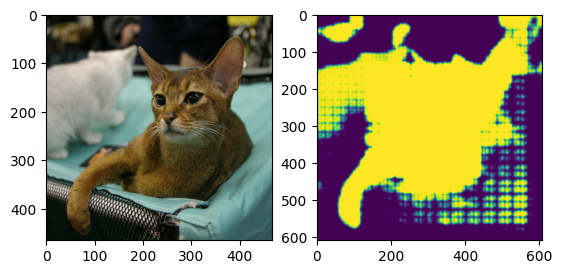

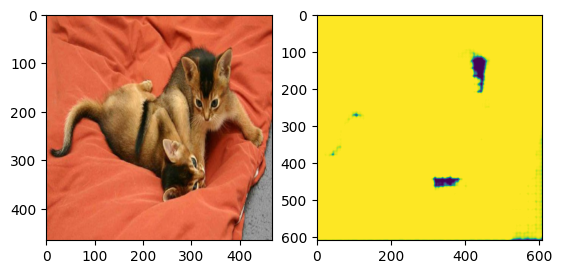

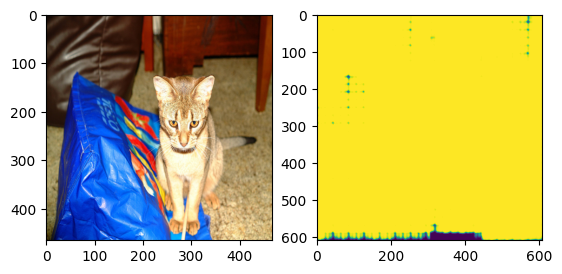

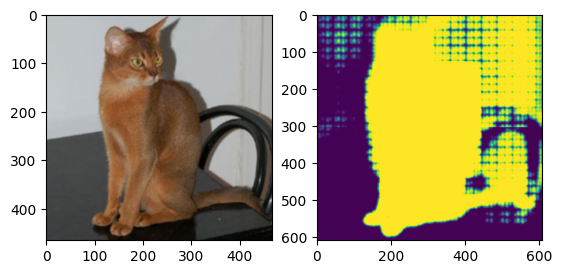

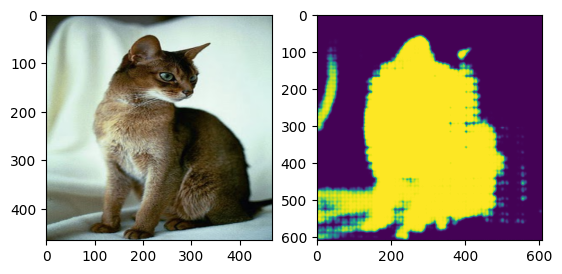

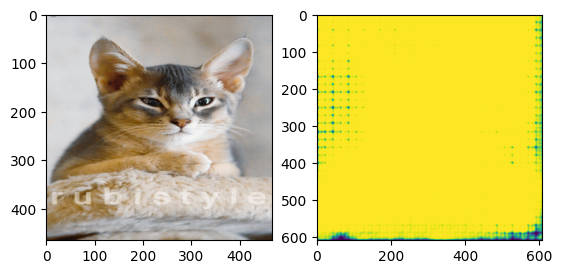

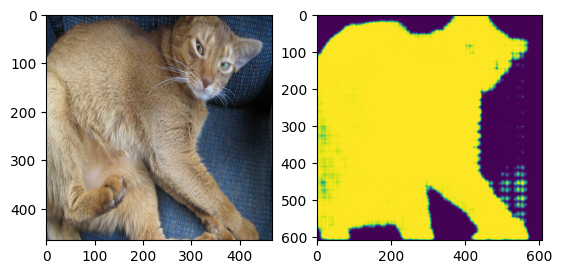

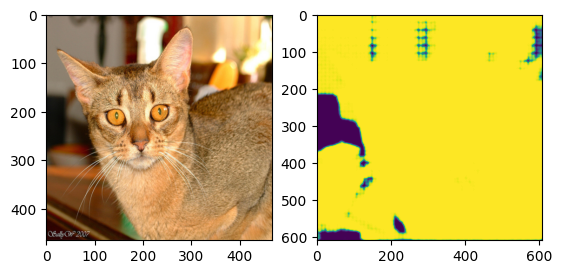

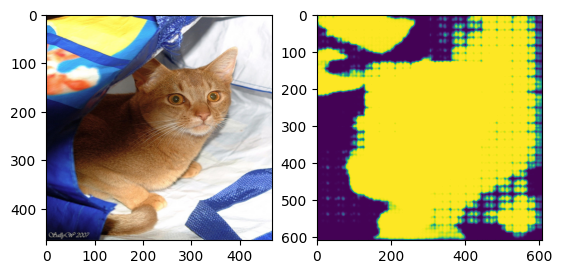

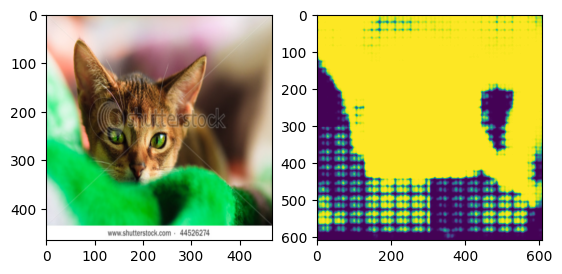

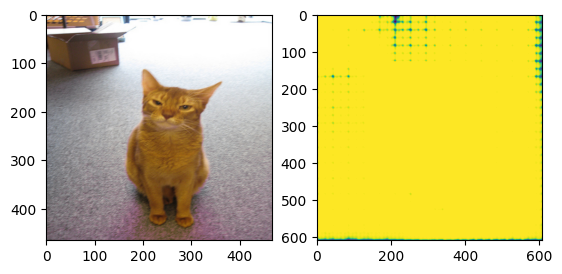

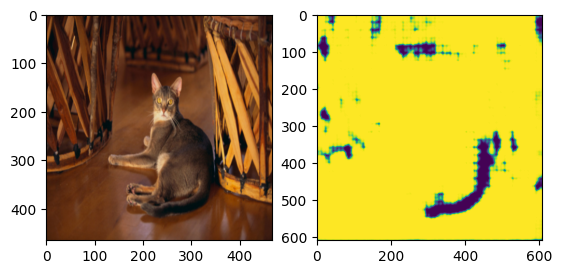

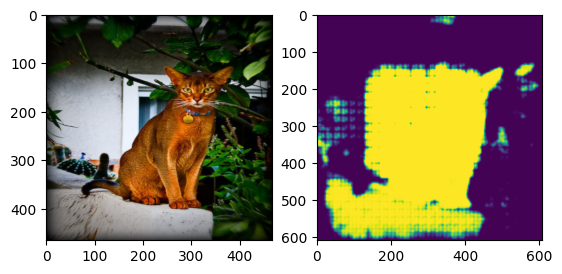

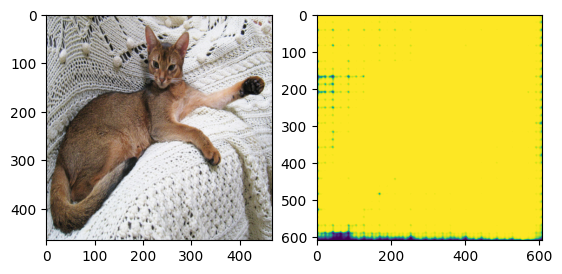

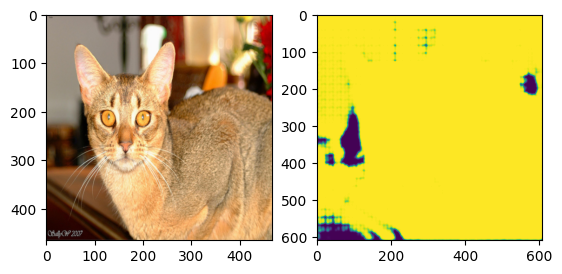

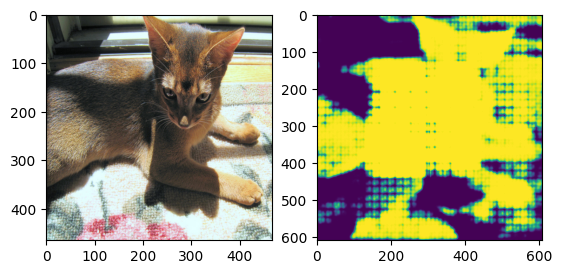

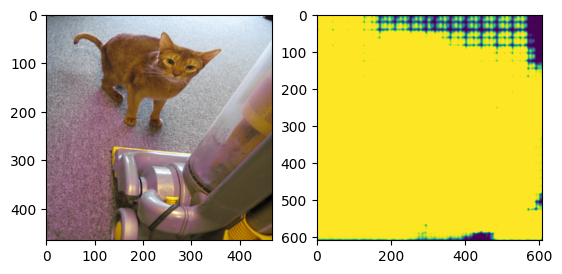

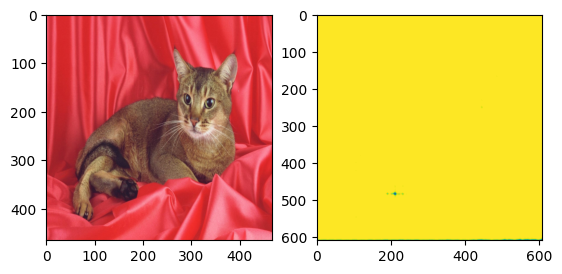

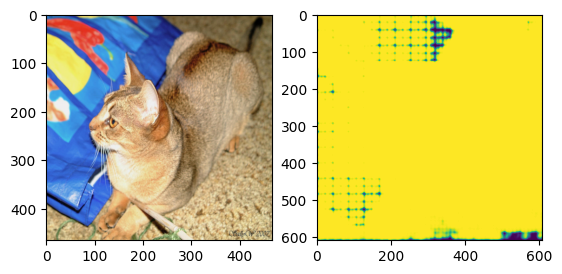

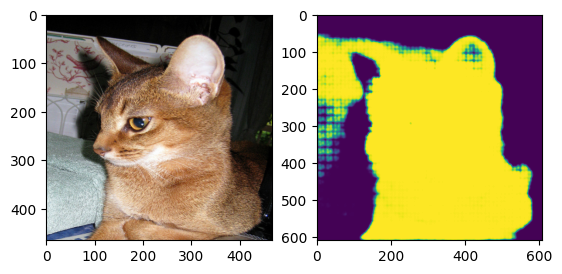

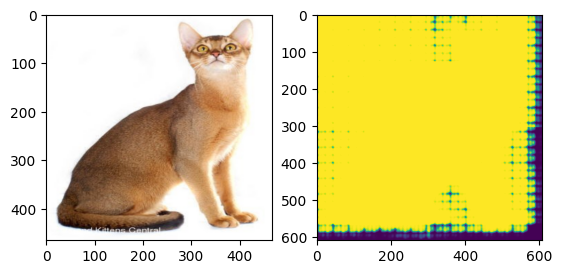

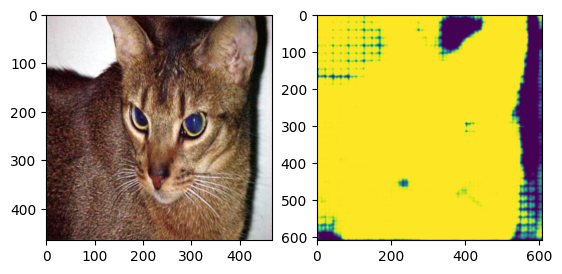

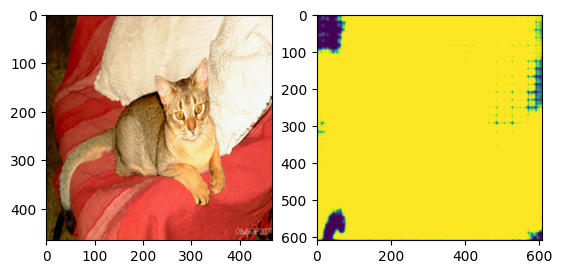

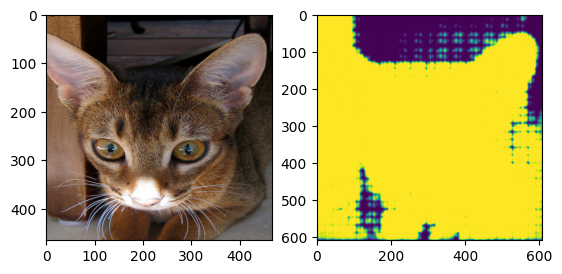

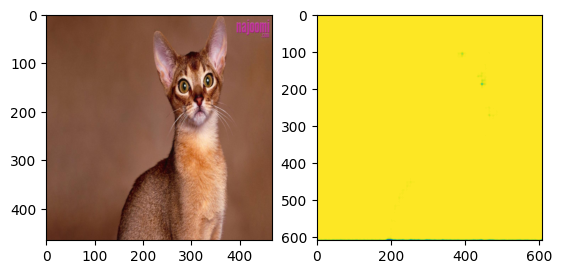

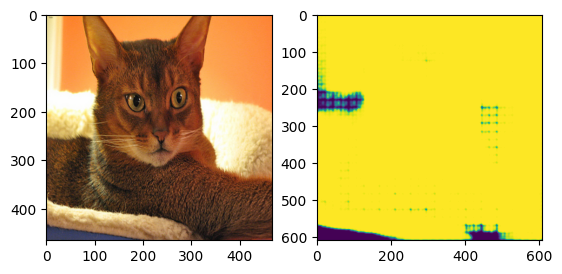

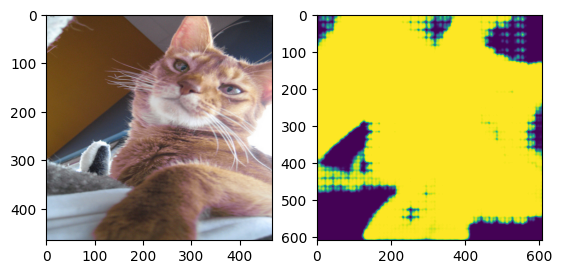

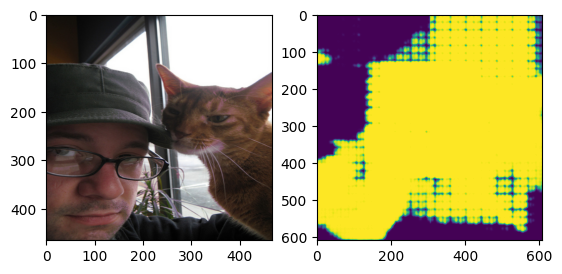

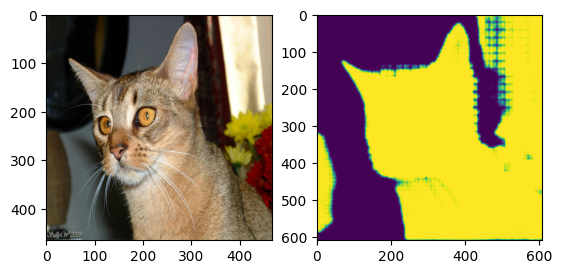

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

for filename in os.listdir(testing_path):
  # print(filename[-3:])
  if filename.lower().endswith('jpg'):
    image_path = os.path.join(testing_path,filename)

    # Load a testing image
    input = np.array(Image.open(image_path)).astype('float32') / 255

    # Resize the testing image
    input = resize(input, (testing_resize, testing_resize))

    # Divide the resized testing image into four patches, one at each corner.
    input_patches = testing_patch_extracting(input, training_resize, testing_resize)
    input_patches = torch.from_numpy(input_patches).float()

    # Predict the mask of the four patches
    if cuda_available:
        output_patches = model(input_patches.cuda()).detach().cpu().numpy()
    else:
        output_patches = model(input_patches).detach().numpy()

    # Merge the four masks into one resized mask
    output = testing_patch_assembling(output_patches, training_resize, testing_resize)[0, :, :]

    # Restore the resized mask to the original resolution
    output = resize(output, (608, 608))

    f, axs = plt.subplots(1, 2)
    axs[0].imshow(input)
    axs[1].imshow(output)

INFER USING OPENCV (IMSHOW)

In [ ]:
for filename in os.listdir(testing_path):
    if filename.lower().endswith('jpg'):
        image_path = os.path.join(testing_path, filename)

        # Load a testing image using OpenCV
        input = cv2.imread(image_path)
        input = cv2.cvtColor(input, cv2.COLOR_BGR2RGB).astype('float32') / 255

        # Resize the testing image
        input = resize(input, (testing_resize, testing_resize))

        # Divide the resized testing image into four patches
        input_patches = testing_patch_extracting(input, training_resize, testing_resize)
        input_patches = torch.from_numpy(input_patches).float()

        # Predict the mask of the four patches
        model.eval()
        with torch.no_grad():
            if cuda_available:
                output_patches = model(input_patches.cuda()).detach().cpu().numpy()
            else:
                output_patches = model(input_patches).detach().numpy()

        # Merge the four masks into one resized mask
        output = testing_patch_assembling(output_patches, training_resize, testing_resize)

        # Restore the resized mask to the original resolution
        output = resize(output, (608, 608))

        # Convert images to uint8 format for OpenCV display
        input_display = (input * 255).astype(np.uint8)
        output_display = (output * 255).astype(np.uint8)

        # Display images using OpenCV
        cv2.imshow('Input Image', cv2.cvtColor(input_display, cv2.COLOR_RGB2BGR))
        cv2.imshow('Output Mask', output_display)

        # Wait for a key press and close the windows
        cv2.waitKey(0)
        cv2.destroyAllWindows()